# Final Network

## Imports

In [ ]:
import sys
from google.colab import drive

# # General math and array operations
import numpy as np
import pandas as pd
import seaborn as sn

#Plots
%matplotlib inline
import matplotlib.pyplot as plt

# # For image loading and data loader
import os
from skimage.io import imread
import natsort

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# Torchvision Imports
import torchvision.transforms as transforms
from torchvision import models

# K-fold Cross Validation
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Mounting Drive

In [ ]:
drive.mount('/content/drive/')
drive_path = 'drive/MyDrive/'
sys.path.insert(0,'/content/drive/MyDrive/project')
drive_path= "drive/MyDrive/project/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Defining Class Weights

In [ ]:
dataset = pd.read_csv(drive_path+'dermx_labels.csv')
dataset = dataset.join(pd.get_dummies(dataset.diagnosis))
weights = dataset.sum()

weights_order_char = np.argsort(weights[2:9])
weights_list_char = np.flip(np.ones(7))
weights_char = np.zeros(7)
weights_char[weights_order_char] = weights_list_char
weights_char[2] = 3
weights_char[5] = 3
weights_char = torch.FloatTensor(weights_char)

weights_order_diag = np.argsort(weights[9:15])
weights_list_diag = np.flip(np.ones(6)+np.arange(0.0, 0.75, 0.125))
#weights_diagnose = np.zeros(6)
#weights_diagnose[weights_order_diag] = (weights_list_diag)

#weights_diagnose = torch.FloatTensor(weights_diagnose)
#weights_diagnose[2] += 0.1
weights_diagnose = np.ones(6)
#weights_diagnose[4] += 1
weights_diagnose = torch.FloatTensor(weights_diagnose)
total_num = 492

print(weights_char)


tensor([1., 1., 3., 1., 1., 3., 1.])


## Defining Image Transformations

In [ ]:
on_load_transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomCrop(195,40),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(degrees = 45),
                                transforms.ColorJitter(brightness = 0.5,contrast=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ])

## Defining Data Loader

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform=on_load_transform,csv_file=drive_path+'dermx_labels.csv'):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)
        diagnosis = []
        symptoms = []
        csvdata = pd.read_csv(csv_file)
        csvdata = csvdata.join(pd.get_dummies(csvdata.diagnosis))
        for file_name in self.total_imgs:
          image_id = file_name.split('.')[0]
          glob_idx = np.where(csvdata.image_id == image_id)[0][0]
          meta = csvdata.iloc[glob_idx]
          symptoms.append([meta.scale,meta.plaque,meta.pustule,meta.patch,meta.papule,meta.dermatoglyph_disruption,meta.open_comedo])
          diagnosis.append([meta.acne,meta.actinic_keratosis,	meta.psoriasis,	meta.seborrheic_dermatitis,	meta.viral_warts,	meta.vitiligo])
        self.diagnosis = torch.tensor(diagnosis)
        self.symptoms = torch.FloatTensor(symptoms)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        #image = Image.open(img_loc).convert("RGB")
        image = imread(img_loc, as_gray=False)
        tensor_image = self.transform(image)
        return tensor_image.to(device=device),self.diagnosis[idx].to(device=device),self.symptoms[idx].to(device=device)

## Defining Test And Training Sets

In [ ]:
img_folder_path = drive_path+'/cleaned_images'
image_dataset = CustomDataSet(img_folder_path)

validation_frac = 0.2
shuffle_dataset = True
random_seed= 42
batch_size = 10

dataset_size = len(image_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_frac * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(image_dataset, batch_size=batch_size,sampler=train_sampler,drop_last=True)
validation_loader = DataLoader(image_dataset, batch_size=batch_size,sampler=validation_sampler,drop_last=True)

## Class Definitions for Multitask Learning Network

### Multitask Loss
- Binary cross entropy
- Cross entropy loss

In [ ]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self,eta=0.5):
        super(MultiTaskLossWrapper, self).__init__()
        self.CEL = nn.CrossEntropyLoss(weight =weights_diagnose )
        self.BCE = nn.BCELoss(weight =weights_char)
        self.eta1 = eta
        self.eta2 = 1.0-eta
    def forward(self, preds, y,z):
        #print(preds[0])
        #print(y)
        loss_CEL = self.CEL(preds[0],y)
        loss_BCE = self.BCE(preds[1],z)

        return self.eta1*loss_CEL+self.eta2*loss_BCE

criterion = MultiTaskLossWrapper().to(device)

In [ ]:
def accuracy(ybar,y,zbar,z):
    y_temp = torch.max(ybar, 1)[1]
    y_res = torch.eq(y_temp, y)
    z_res = torch.eq(torch.round(zbar),z)
    return 0.7*torch.mean(y_res.float())+(1-0.7)*torch.mean(z_res.float())

# def get_numpy(x):
#     """ Get numpy array for both cuda and not. """
#     if use_cuda:
#         return x.cpu().data.numpy()
#     return x.data.numpy()

### Defining the F1 Score

In [ ]:
#def F1_score(prob, label):
#    prob = prob.bool()
#    label = label.bool()
#    epsilon = 1e-7
#    F2 = 0
#    for i in range(len(prob)):
#      TP = (prob[i] & label[i]).sum().float()
#      TN = ((~prob[i]) & (~label[i])).sum().float()
#      FP = (prob[i] & (~label[i])).sum().float()
#      FN = ((~prob[i]) & label[i]).sum().float()
#      #accuracy = (TP+TN)/(TP+TN+FP+FN)
#      precision = torch.mean(TP / (TP + FP + epsilon))
#      recall = torch.mean(TP / (TP + FN + epsilon))
#      F2 += (2 * precision * recall / (precision + recall + epsilon))
#      
#    return precision, recall, (F2/len(prob))

def F1_score(prob, label,type):
  if(type == "diagnose"):
    lengt = 6
    prob = torch.max(prob, 1)[1]
    F2 = 0
    for i in range(len(prob)):
      prob_vec = torch.zeros(lengt)
      label_vec = torch.zeros(lengt)
      prob_vec[prob[i]] = 1
      label_vec[label[i]] = 1
      prob_vec = prob_vec.bool()
      label_vec = label_vec.bool()
    #epsilon = 1e-7
      
    
    #for j in range(len(prob_vec)):
      TP = (prob_vec & label_vec).sum().float()
      TN = ((~prob_vec & ~label_vec)).sum().float()
      FP = (prob_vec & ~label_vec).sum().float()
      FN = (~prob_vec & label_vec).sum().float()
    #accuracy = (TP+TN)/(TP+TN+FP+FN)
      if(TP == 0):
        F2 += 0
      else:
        precision = torch.mean(TP / (TP + FP))
        recall = torch.mean(TP / (TP + FN ))
        F2 += (2 * precision * recall / (precision + recall ))

  else:
    prob_vec = prob >=1/7
    prob_vec = prob_vec.bool()
    label_vec = label.bool()
    F2 = 0
    for i in range(len(prob)):
      TP = (prob_vec[i] & label_vec[i]).sum().float()
      TN = ((~prob_vec[i] & ~label_vec[i])).sum().float()
      FP = (prob_vec[i] & ~label_vec[i]).sum().float()
      FN = (~prob_vec[i] & label_vec[i]).sum().float()
    #accuracy = (TP+TN)/(TP+TN+FP+FN)
      if(TP == 0):
        F2 += 0
      else:
        precision = torch.mean(TP / (TP + FP))
        recall = torch.mean(TP / (TP + FN ))
        F2 += (2 * precision * recall / (precision + recall ))
      
  return (F2/len(prob))

### Initializing ResNet Model

In [ ]:
model = models.resnet18(pretrained=True)
k = 0
for param in model.parameters():
  k +=1
  if k <= 55: #55
    param.requires_grad = False
  #print(param.requires_grad)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Defining Multitask Classification Network


In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class MultiTaskClassification(nn.Module):
  def __init__(self,arch):
    super(MultiTaskClassification, self).__init__()
    model = arch
    self.conv1 = model.conv1
    self.bn1 = model.bn1
    self.relu = model .relu
    self.maxpool = model.maxpool
    self.layer1 = model.layer1
    self.layer2 = model.layer2
    self.layer3 = model.layer3
    self.layer4 = model.layer4
    self.avgpool = model.avgpool

    self.char = nn.Sequential(nn.Linear(512,256),nn.BatchNorm1d(256),nn.Tanh(),nn.Linear(256,7),nn.BatchNorm1d(7))
    #self.diagnose = nn.Sequential(nn.Linear(512+7,256),nn.BatchNorm1d(256),nn.Tanh(),nn.Linear(256,6),nn.BatchNorm1d(6))
    self.diagnose = nn.Sequential(nn.Linear(512,256),nn.BatchNorm1d(256),nn.Tanh(),nn.Linear(256,6),nn.BatchNorm1d(6))

    self.char.apply(init_weights)
    self.diagnose.apply(init_weights)


    self.dropout = nn.Dropout(p=0.5)

  def forward(self,x):

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = self.dropout(x)

    # x = x.view(x.size(0), 512)
    # x_char = self.char(x)
    # x_char = torch.softmax(x_char,dim = 1)
    # x_combined = torch.cat((x,x_char.view(x_char.size(0), 7)), dim=1)
    # x_diagnose = self.diagnose(x_combined)
    # x_diagnose = torch.softmax(x_diagnose,dim = 1)

    x = x.view(x.size(0), 512)
    x_char = self.char(x)
    x_char = torch.softmax(x_char,dim = 1)
    x_diagnose = self.diagnose(x)
    x_diagnose = torch.softmax(x_diagnose,dim = 1)
    return x_diagnose, x_char

### Function to Initialize a Multiclass Learning Network

In [ ]:
def init_new_model():
  model = models.resnet18(pretrained=True)
  k = 0
  for param in model.parameters():
    k +=1
    #55
    if k <= 55:
      param.requires_grad = False

  model.to(device)
  multi_model = MultiTaskClassification(model).to(device)
  multi_model.train()
  return multi_model

### Defining Function For Plotting

In [ ]:
def model_metrics_plots(fold_num,metrics_symp,metrics_diag,title=0,savefig=False):
    fig = plt.figure(figsize=(8,6))
    plt.plot(metrics_diag.train.iter, metrics_diag.train.loss, label='train_loss',linewidth=2)
    plt.plot(metrics_diag.valid.iter, metrics_diag.valid.loss, label='valid_loss',linewidth=2)
    plt.legend(fontsize=20)
    plt.xlabel("Epoch",fontsize=20)
    plt.ylabel("Loss",fontsize=20)
    plt.title("Combined Loss",fontsize=24)
    if savefig:
      plt.savefig(drive_path+"loss.pdf")
    plt.show()

    fig = plt.figure(figsize=(8,6))
    plt.plot(metrics_diag.train.iter, metrics_diag.train.F1,'-',label='diagnosis_train_F1',color='blue',linewidth=2)
    plt.plot(metrics_diag.valid.iter, metrics_diag.valid.F1,'-',label='diagnosis_valid_F1',color='orange',linewidth=2)
    plt.legend(fontsize=20)
    plt.xlabel("Epoch",fontsize=20)
    plt.ylabel("F1",fontsize=20)
    plt.title("F1 Diagnosis",fontsize=24)
    if savefig:
      plt.savefig(drive_path+"diagnosis_f1.pdf")
    plt.show()

    fig = plt.figure(figsize=(8,6))
    plt.plot(metrics_symp.train.iter, metrics_symp.train.F1,'-',label='symptom_train_F1',color='blue',linewidth=2)
    plt.plot(metrics_symp.valid.iter, metrics_symp.valid.F1,'-',label='symptom_valid_F1',color='orange',linewidth=2)
    plt.legend(fontsize=20)
    plt.xlabel("Epoch",fontsize=20)
    plt.ylabel("F1",fontsize=20)
    plt.title("F1 Symptoms",fontsize=24)
    if savefig:
      plt.savefig(drive_path+"characteristic_f1.pdf")
    
    plt.show()

### Defining Class for Collecting Metrics

In [ ]:
class single_metrics_class:
  def __init__(self):
    #self.precision = []
    #self.recall = []
    self.F1 = []
    self.loss = []
    self.iter = []

    #self.val_pre = 0
    #self.val_rec = 0
    self.val_F1 = 0
    self.val_iter = 0

  def append_batch(self,precision,recall,F1):
    #self.val_pre += precision
    #self.val_rec += recall
    self.val_F1 += F1
    self.val_iter += 1
  
  def update(self,iter,loss):
    #self.precision.append(self.val_pre/self.val_iter)
    #self.recall.append(self.val_rec/self.val_iter)
    self.F1.append(self.val_F1/self.val_iter)
    self.loss.append(loss)
    self.iter.append(iter)
    #self.val_pre = 0
    #self.val_rec = 0
    self.val_F1 = 0
    self.val_iter = 0

class model_metrics_class:
  def __init__(self):
    self.train = single_metrics_class()
    self.valid = single_metrics_class()

### Settings for Optimizer and Learning Rate Scheduler

[0.0008, 0.0006013333333333334, 0.0002040000000000001, 0.0008, 0.0007467674271036838, 0.0006013333333333334, 0.0004026666666666667, 0.0002040000000000001, 5.856590622964969e-05, 0.0008, 0.0007864611949788564, 0.0007467674271036838, 0.0006836237610581215, 0.0006013333333333334, 0.0005055041005874016, 0.0004026666666666667, 0.0002998292327459318, 0.0002040000000000001, 0.00012170957227521182, 5.856590622964969e-05, 1.88721383544769e-05, 0.0008, 0.0007966007582525275, 0.0007864611949788564, 0.000769754800917818, 0.0007467674271036838, 0.0007178923938757174, 0.0006836237610581215, 0.000644547874459465, 0.0006013333333333334, 0.0005547195504597291, 0.0005055041005874016, 0.00045452907370876724, 0.0004026666666666667, 0.0003508042596245662, 0.0002998292327459318, 0.00025061378287360444, 0.0002040000000000001, 0.00016078545887386836, 0.00012170957227521182, 8.744093945761594e-05, 5.856590622964969e-05, 3.5578532415515406e-05, 1.88721383544769e-05, 8.732575080806008e-06]


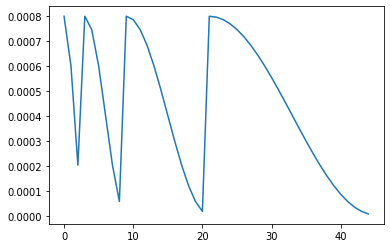

In [ ]:
learning_rate = 8e-5
cycle_length = 3
cycle_multiplier = 2
epochs = 45

## For plot only
learning_rates = []
multi_model = MultiTaskClassification(model).to(device) 
optimizer = optim.SGD(multi_model.parameters(), lr=learning_rate*10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cycle_length,T_mult=cycle_multiplier,eta_min=learning_rate/15)
for i in range(epochs):
  learning_rates.append(optimizer.param_groups[0]["lr"])
  scheduler.step()

plt.plot(learning_rates)
print(learning_rates)
del multi_model

## Class for Cross Validation Stats

In [ ]:
class CV_stats():
  def __init__(self):
    self.val_accs2 = []
    self.valid_accs1 = []
    self.valid_accs2 = []
    self.train_accs2 = []
    self.train_accs1 = []
    self.val_accs1 = []
    self.train_ac1_final = 0
    self.train_ac2_final = 0
    self.val_ac1_final = 0
    self.val_ac2_final = 0

### Defining Training Loop

In [ ]:
def training_loop(epoch,loader,network,optimizer,criterion,metrics1,metrics2,cvmetrics):
    train_losses = 0
    train_ac = 0
    train_lengths = 0
    train_acs1, train_acs2 = 0, 0
    network.train()
    for num,batch_train in enumerate(loader):
        x,y,z = batch_train
        output = network(x)
        y_bar = output[0]
        z_bar = output[1]
        y_argmax = torch.max(y, 1)[1]
        batch_loss = criterion(output, y_argmax,z)
        train_lengths += 1
        train_ac += accuracy(y_bar,y_argmax,z_bar,z)
        score1 = F1_score(z_bar,z, "Char")
        score2 = F1_score(y_bar,y_argmax,"diagnose")
        #print("Traning", score2)
        
        precision1 = 0
        precision2 = 0
        recall1 = 0
        recall2 = 0
        #precision1,recall1,score1 = F1_score(z_bar,z)
        #precision2,recall2,score2 = F1_score(y_bar,y_argmax)
        train_acs1 += score1
        train_acs2 += score2
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        train_losses += batch_loss.detach().cpu().numpy()

        metrics1.train.append_batch(precision1,recall1,score1)
        metrics2.train.append_batch(precision2,recall2,score2)

        x.detach();y.detach();z.detach();y_bar.detach();z_bar.detach();y_argmax.detach();batch_loss.detach();
        del x
        del y
        del z
        del y_bar
        del z_bar
        del y_argmax
        del batch_loss
        torch.cuda.empty_cache()
    train_losses /= train_lengths
    train_acs1 /= train_lengths
    train_acs2 /= train_lengths

    cvmetrics.train_accs1.append(train_acs1)
    cvmetrics.train_accs2.append(train_acs2)
    cvmetrics.train_ac1_final += train_acs1
    cvmetrics.train_ac2_final += train_acs2

    metrics1.train.update(epoch,train_losses)
    metrics2.train.update(epoch,train_losses)

### Defining Test Loop

In [ ]:
def test_loop(epoch,loader,network,optimizer,criterion,metrics1,metrics2,cvmetrics):
    # print("id of loader is " + str(id(loader)))
    # print("id of network is " + str(id(network)))
    # print("id of optimizer is " + str(id(optimizer)))
    # print("id of metrics1 is " + str(id(metrics1)))
    # print("id of metrics2 is " + str(id(metrics2)))
    # print("id of cvmetrics is " + str(id(cvmetrics)))
    network.eval()
    val_losses, val_accs1, val_accs2, val_lengths = 0, 0, 0,0
    for num,batch_valid in enumerate(loader):
        num = num +1
        x,y,z = batch_valid
        output = network(x)
        y_bar = output[0]
        z_bar = output[1]
        y_argmax = torch.max(y, 1)[1]
        val_losses += criterion(output, y_argmax,z)
        score1 = F1_score(z_bar,z, "Char")
        score2 = F1_score(y_bar,y_argmax,"diagnose")
        #print("Test", score2)
        precision1 = 0
        precision2 = 0
        recall1 = 0
        recall2 = 0
        #precision1,recall1,score1 = F1_score(z_bar,z)
        #precision2,recall2,score2 = F1_score(y_bar,y_argmax)
        val_accs1 += score1
        val_accs2 += score2
        val_lengths += 1
        metrics1.valid.append_batch(precision1,recall1,score1)
        metrics2.valid.append_batch(precision2,recall2,score2)
        x.detach();y.detach();z.detach();y_bar.detach();z_bar.detach();y_argmax.detach();
        del x
        del y
        del z
        del y_bar
        del z_bar
        del y_argmax
        torch.cuda.empty_cache()
        
    # Divide by the total accumulated batch sizes
    val_losses /= val_lengths
    val_accs1 /= val_lengths
    val_accs2 /= val_lengths

    cvmetrics.valid_accs1.append((val_accs1))
    cvmetrics.valid_accs2.append((val_accs2))
    cvmetrics.val_ac1_final += val_accs1
    cvmetrics.val_ac2_final += val_accs2

    # for plots
    metrics1.valid.update(epoch,val_losses)
    metrics2.valid.update(epoch,val_losses)

    network.train()

In [ ]:
def get_conf_matrix(multi_model,train_loader):
  conf_mat = np.zeros((6,6))

  multi_model.eval()
  for num,batch_valid in enumerate(train_loader):
    x,y,_ = batch_valid
    output = multi_model(x)
    y_bar = torch.max(output[0], 1)[1]
    y_argmax = torch.max(y, 1)[1]
    y_bar = y_bar.cpu().data.numpy()
    y_argmax = y_argmax.cpu().data.numpy()
    for ind in range(6):
      conf_mat[y_argmax[ind]][y_bar[ind]] += 1
  return conf_mat

## K Fold Cross Validation

Fold number 1 of 5
Allocated: 47934464
Reserved: 69206016


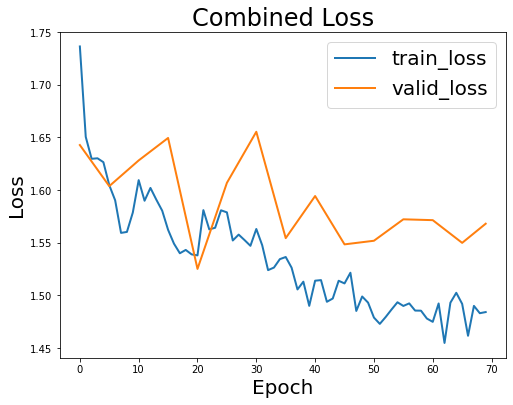

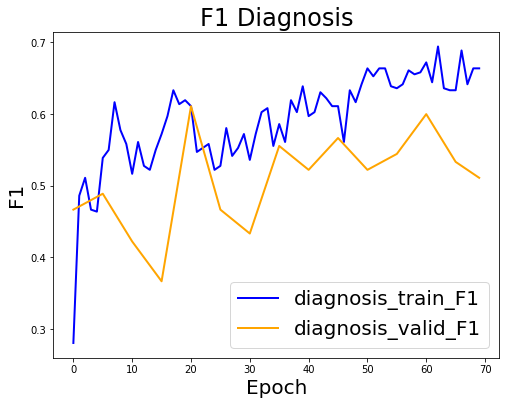

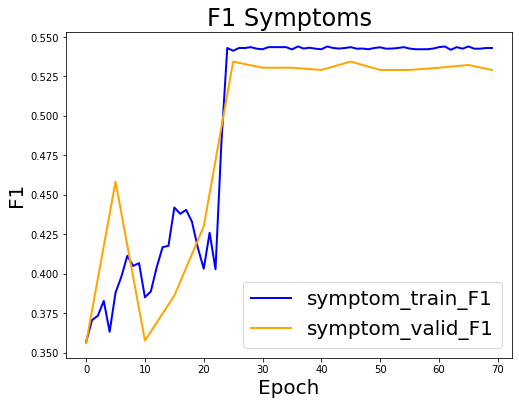

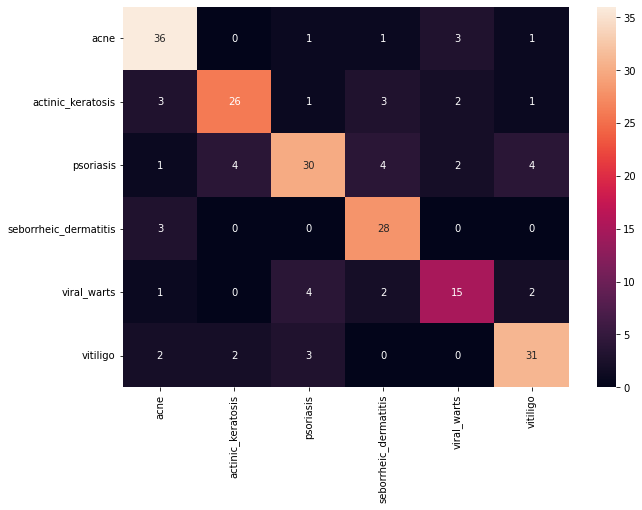

Fold number 2 of 5
Allocated: 676062720
Reserved: 736100352


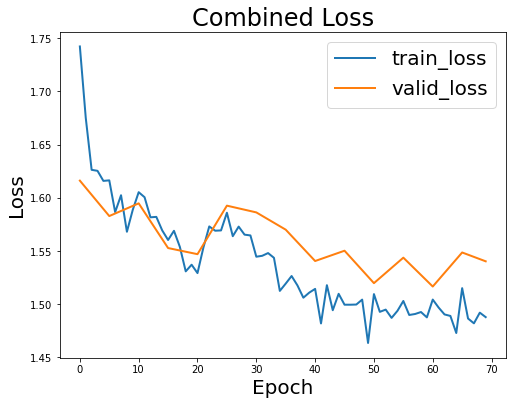

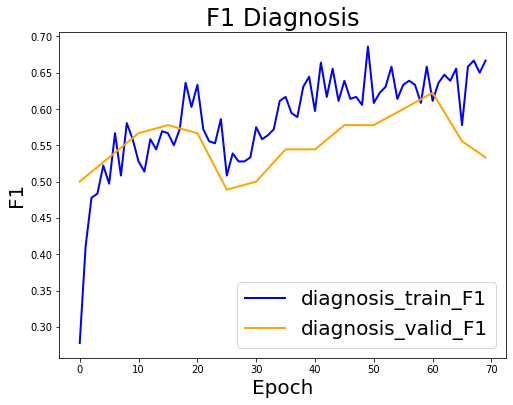

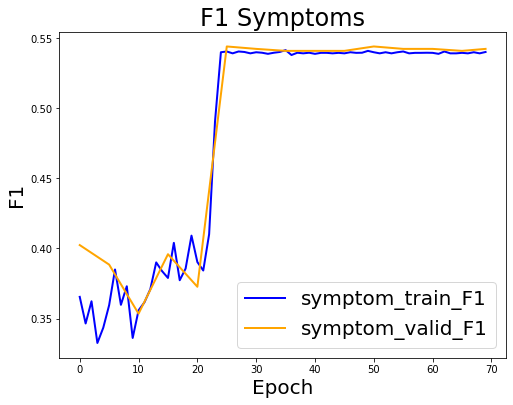

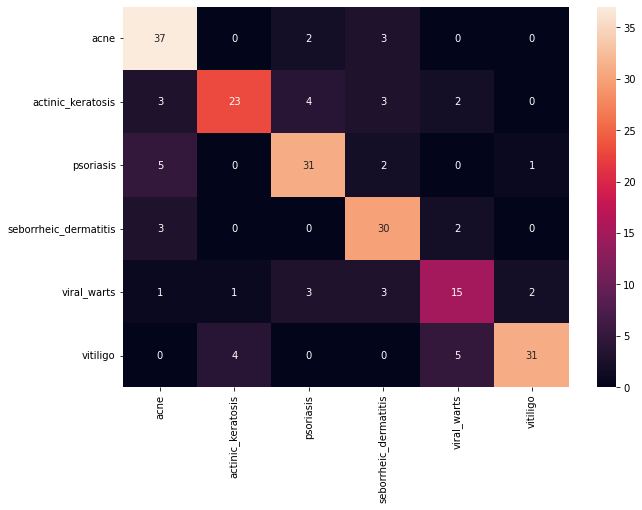

Fold number 3 of 5
Allocated: 1248878080
Reserved: 1304428544


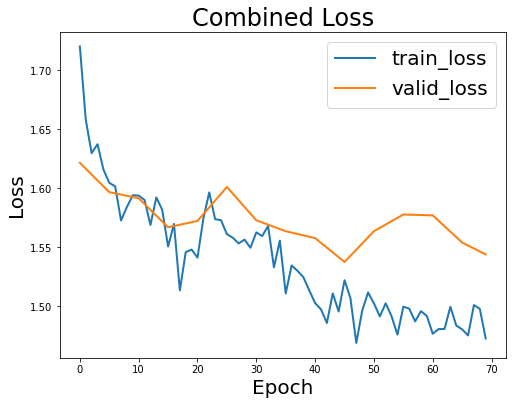

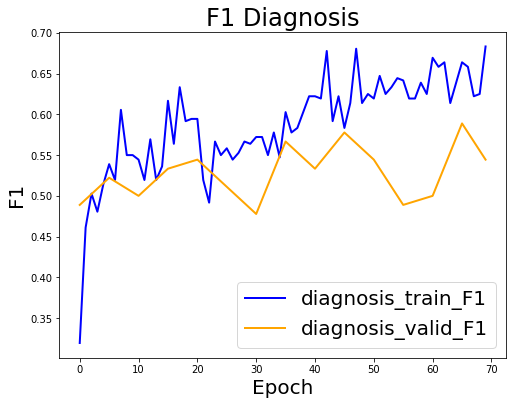

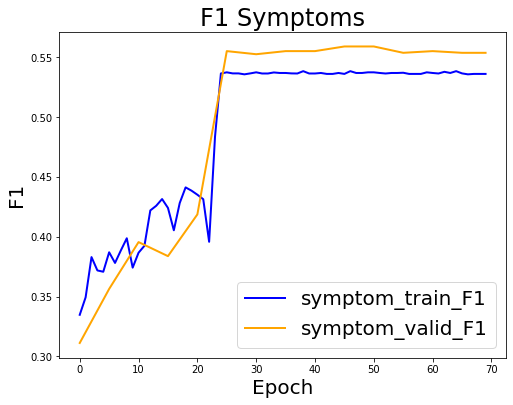

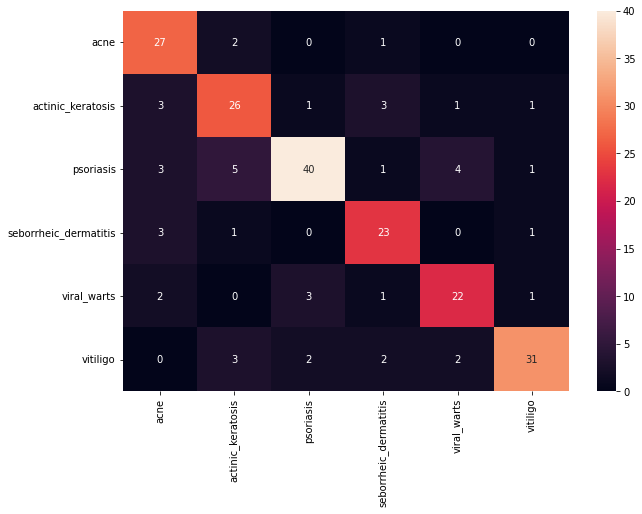

Fold number 4 of 5
Allocated: 1823528448
Reserved: 1897922560


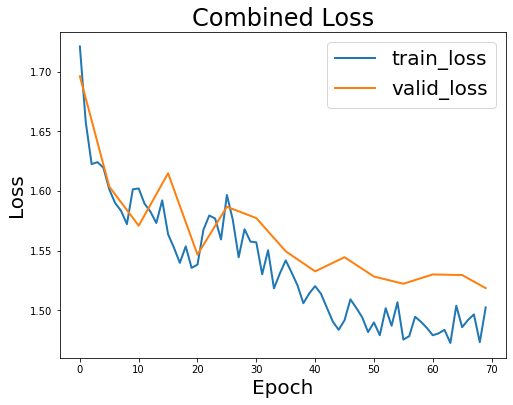

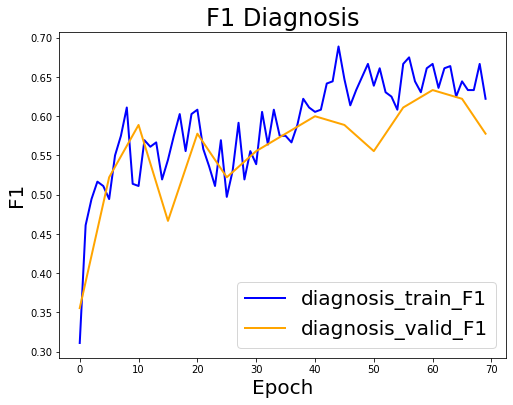

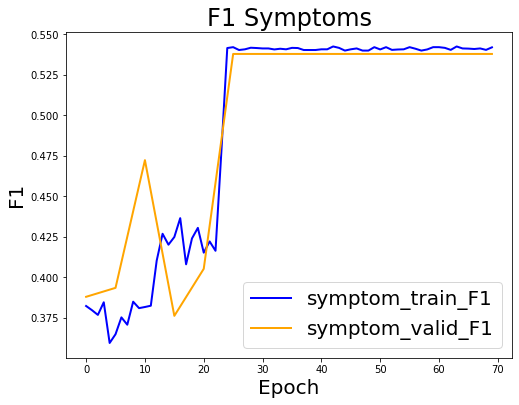

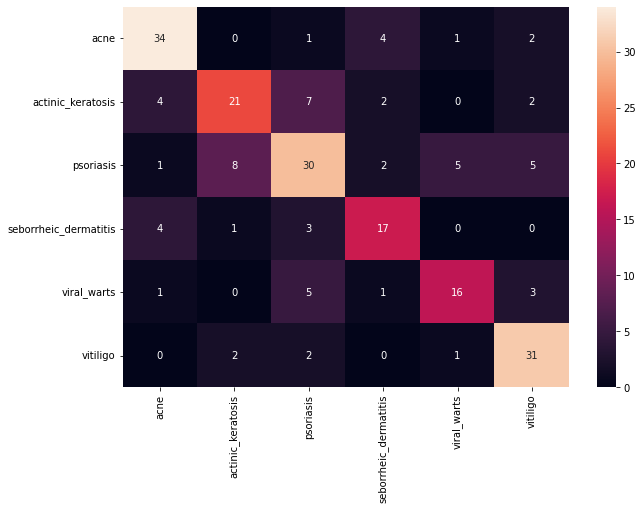

Fold number 5 of 5
Allocated: 2396343808
Reserved: 2487222272


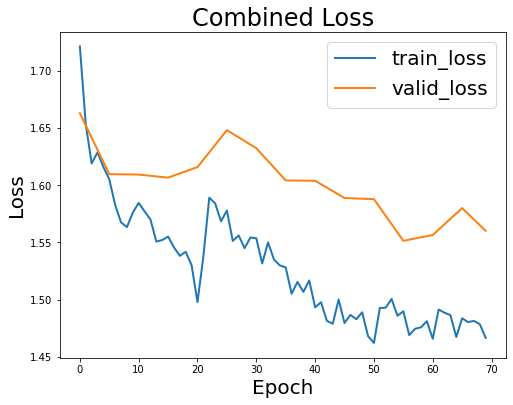

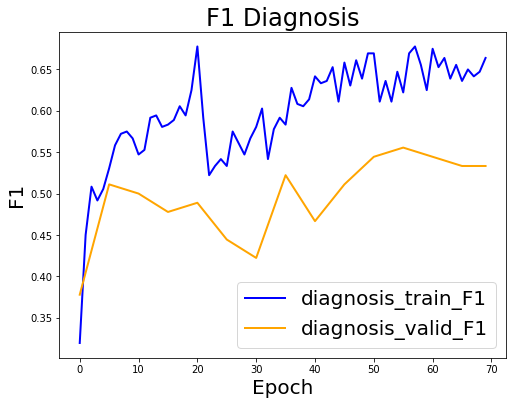

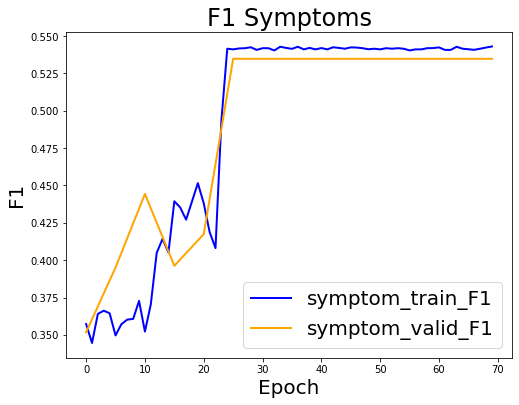

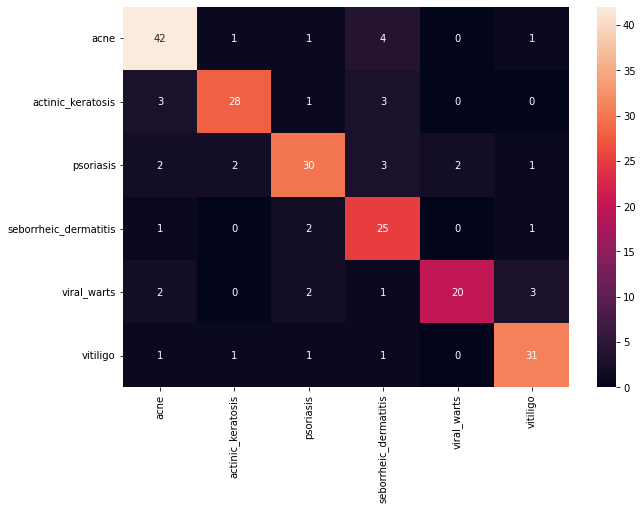

In [ ]:
CV_loss_val = []
CV_loss_train = []

all_symptoms = []
all_diagnosis = []

diagnosis = ['acne','actinic_keratosis',	'psoriasis','seborrheic_dermatitis','viral_warts','vitiligo']

log_every = 10
eval_every = 5
kfold = KFold(n_splits=5, shuffle=True)

conf_mat_mean = np.zeros((6,6))

# learning_rate = 3e-2

# criterion = MultiTaskLossWrapper(eta=0.7).to(device)

learning_rate = 8e-5

criterion = MultiTaskLossWrapper(eta=1.0).to(device)

num_epochs = 70  #93
for fold, (train_ids, test_ids) in enumerate(kfold.split(image_dataset)):
  fold_metrics = CV_stats()
  print("Fold number "+str(fold+1) + " of 5")
  print("Allocated: "+str(torch.cuda.memory_allocated()))
  print("Reserved: "+str(torch.cuda.memory_reserved()))
  Validation_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  Traning_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)

  validation_loader = DataLoader(image_dataset, batch_size=batch_size,sampler=Validation_subsampler,drop_last=True)
  train_loader = DataLoader(image_dataset, batch_size=batch_size,sampler=Traning_subsampler,drop_last=True)

  # Defining new model
  multi_model = init_new_model()

  # Defining learning rate scheduler
  #optimizer = optim.SGD(multi_model.parameters(), lr=learning_rate)
  optimizer = optim.Adam(multi_model.parameters(), lr=learning_rate*10,weight_decay=0.005)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cycle_length,T_mult=cycle_multiplier,eta_min=learning_rate/15)

  # # For plotting
  metrics_char = model_metrics_class()
  metrics_diag = model_metrics_class()
  for epoch in range(num_epochs):
    #print("Allocated: "+str(torch.cuda.memory_allocated()))
    #print("Reserved: "+str(torch.cuda.memory_reserved()))
    #torch.cuda.memory_summary(device=None, abbreviated=False)
    # Training
    training_loop(epoch,train_loader,multi_model,optimizer,criterion,metrics_char,metrics_diag,fold_metrics)

    # Validation
    if (epoch % eval_every == 0) or (epoch == (num_epochs-1)):
       test_loop(epoch,validation_loader,multi_model,optimizer,criterion,metrics_char,metrics_diag,fold_metrics)

    # Updating learning rate
    if epoch < 44:
      scheduler.step()

  model_metrics_plots(fold,metrics_char,metrics_diag)
  all_symptoms.append(metrics_char)
  all_diagnosis.append(metrics_diag)

  conf_mat = get_conf_matrix(multi_model,train_loader)

  df_cm = pd.DataFrame(conf_mat, index = diagnosis,
                    columns = diagnosis)
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)
  plt.show()

  conf_mat_mean += conf_mat

  CV_loss_val.append([(fold_metrics.val_ac1_final),(fold_metrics.val_ac2_final)])
  CV_loss_train.append([(fold_metrics.train_ac1_final),(fold_metrics.train_ac1_final)])

  del multi_model
  del optimizer
  del scheduler
  torch.cuda.empty_cache()

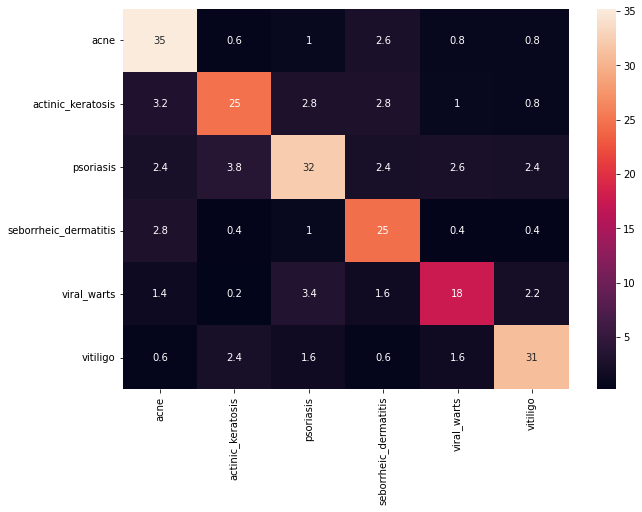

In [ ]:
df_cm = pd.DataFrame(conf_mat_mean/5, index = diagnosis,
                    columns = diagnosis)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

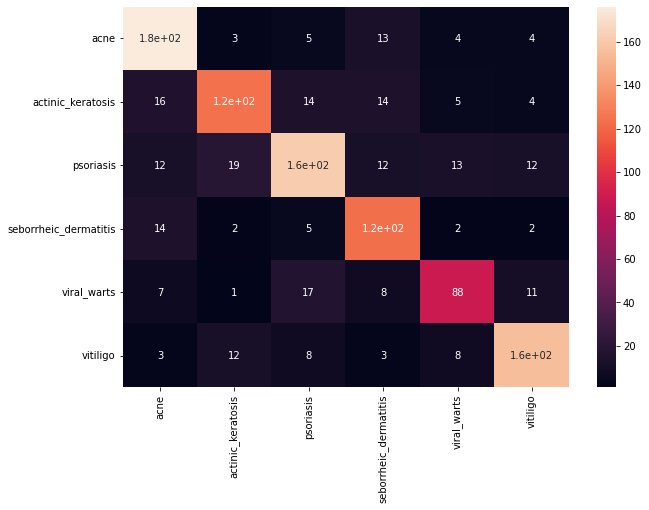

In [ ]:
df_cm = pd.DataFrame(conf_mat_mean, index = diagnosis,
                    columns = diagnosis)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

1
[0.36545196 0.34645283 0.3623016  0.3325397  0.34343696 0.35954145
 0.38500443 0.35976636 0.3730225  0.33610895 0.35584655 0.3615366
 0.3709127  0.39004412 0.3838052  0.37894621 0.40400898 0.37731925
 0.38564378 0.40915343 0.39027992 0.38425925 0.4101896  0.49058214
 0.5400304  0.54057056 0.5392448  0.5405706  0.54021704 0.53924483
 0.5400304  0.5396769  0.53889126 0.5396769  0.5402171  0.5415428
 0.53805286 0.5396769  0.53924483 0.5396769  0.53889114 0.5395983
 0.53959835 0.53924483 0.5395983  0.5392449  0.5400305  0.5395984
 0.5396768  0.5410026  0.5400304  0.53924483 0.5400305  0.5392448
 0.5400304  0.5405706  0.5392448  0.5395983  0.53959846 0.5396769
 0.5395983  0.53889126 0.54057056 0.5392448  0.53924483 0.5395983
 0.53924483 0.5400304  0.53924483 0.540217  ]
2
[0.33479932 0.34939814 0.38301364 0.37187165 0.37077382 0.38703707
 0.37814155 0.38867724 0.3987478  0.37420198 0.3866799  0.39245597
 0.42201278 0.42588183 0.4315278  0.42410266 0.4054211  0.42819887
 0.44125882 0.43853

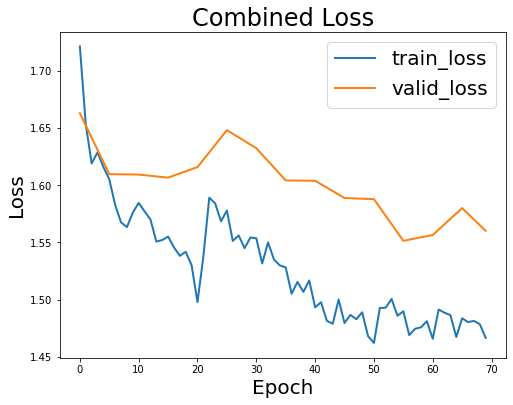

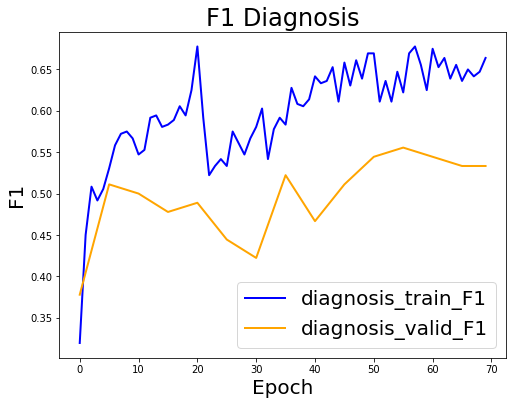

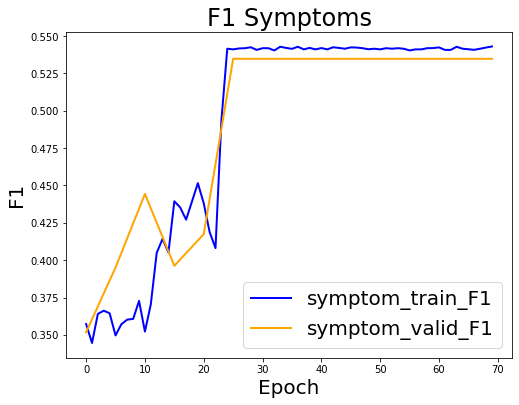

In [ ]:
def extract(y):
  return np.array([item.cpu().numpy() for item in y])

total_symptoms = model_metrics_class()
total_symptoms.train.iter = all_symptoms[0].train.iter
total_symptoms.train.F1 = 0.2*extract(all_symptoms[0].train.F1)
total_symptoms.train.loss = 0.2*np.array(all_symptoms[0].train.loss)
total_symptoms.valid.iter = all_symptoms[0].valid.iter
total_symptoms.valid.F1 = 0.2*extract(all_symptoms[0].valid.F1)
total_symptoms.valid.loss = 0.2*np.array(all_symptoms[0].valid.loss)
sd_f1_diag_train = []
sd_f1_diag_validation = []
sd_f1_char_train = []
sd_f1_char_validation = []

for i in range(1,5):
    print(i)
    metric = all_symptoms[i]
    print(extract(metric.train.F1))
    total_symptoms.train.F1 += 0.2*extract(metric.train.F1)
    total_symptoms.train.loss += 0.2*np.array(metric.train.loss)
    total_symptoms.valid.F1 += 0.2*extract(metric.valid.F1)
    total_symptoms.valid.loss += 0.2*np.array(metric.valid.loss)
    sd_f1_char_train.append(extract(metric.train.F1))
    sd_f1_char_validation.append(extract(metric.valid.F1))

total_diagnosis = model_metrics_class()
total_diagnosis.train.iter = all_diagnosis[i].train.iter
total_diagnosis.train.F1 = 0.2*extract(all_diagnosis[i].train.F1)
total_diagnosis.train.loss = 0.2*np.array(all_diagnosis[i].train.loss)
total_diagnosis.valid.iter = all_diagnosis[i].valid.iter
total_diagnosis.valid.F1 = 0.2*extract(all_diagnosis[i].valid.F1)
total_diagnosis.valid.loss = 0.2*np.array(all_diagnosis[i].valid.loss)
for i in range(1,5):
    metric = all_diagnosis[i]
    total_diagnosis.train.F1 += 0.2*extract(metric.train.F1)
    total_diagnosis.train.loss += 0.2*np.array(metric.train.loss)
    total_diagnosis.valid.F1 += 0.2*extract(metric.valid.F1)
    total_diagnosis.valid.loss += 0.2*np.array(metric.valid.loss)
    sd_f1_diag_train.append(extract(metric.train.F1))
    sd_f1_diag_validation.append(extract(metric.valid.F1))

model_metrics_plots(0,metrics_char,metrics_diag,title="Model Stats Averaged over 5 Folds")

In [ ]:
sd_diag_train = np.std(sd_f1_diag_train,axis=0)[-1]
sd_diag_vald = np.std(sd_f1_diag_validation,axis=0)[-1]

sd_char_train = np.std(sd_f1_char_train,axis=0)[-1]
sd_char_vald = np.std(sd_f1_char_validation,axis=0)[-1]

f1_train_diag =np.mean(sd_f1_diag_train, axis = 0)[-1]
f1_valid_diag = np.mean(sd_f1_diag_validation, axis = 0)[-1]

f1_train_char = np.mean(sd_f1_char_train, axis = 0)[-1]
f1_valid_char = np.mean(sd_f1_char_validation, axis = 0)[-1]

print("Mean f1 train diag ", f1_train_diag)
print("Mean f1 validation diag ", f1_valid_diag)

print("Mean f1 train char ", f1_train_char)
print("Mean f1 validation char ", f1_valid_char)


print("SD f1 train diag ", sd_diag_train)
print("SD f1 validation diag ", sd_diag_vald)

print("SD f1 train char ", sd_char_train)
print("SD f1 validation char ", sd_char_vald)

Mean f1 train diag  0.6590278
Mean f1 validation diag  0.54722226
Mean f1 train char  0.54034823
Mean f1 validation char  0.5422232
SD f1 train diag  0.022513315
SD f1 validation diag  0.018215083
SD f1 train char  0.0026736232
SD f1 validation char  0.007155903


* Class weights **done**
*   Ændret f1 score  **done**
*   Plots på tværs af CV **Done**
* Cross validation på alle modellen **Done**
* En notebook per model **Done**
* Overfør Plots på tværs af CV til alle notebook **Anton**
* Kørt alt **Begge**
* Kig vægte **Done**
* Juster vægt mellem de to classification problem **Begge**
* Rappoter usikkerhed på tværs af folds **Done** mangler nok mean over dem alle eller som del af plot

**Poster**
* Data resume table **Done**
* Under data tilføj at vi bruger CV **Done**
* Learning rate graf under model architecture **Done**
* Skrive hvilken optimizer vi brugte **Done**
* Resultater **Begge**


